In [4]:
import sys
sys.path.append('../../Codes/lib/')
from funcs import*
from funcs_mini import*
from numba import njit, prange

In [5]:
@njit
def normalize_motif(motif, l, epi):
    """
    Normalize the motif by subtracting the minimum value per column.
    """
    E_m = -3
    for i in range(l):
        # Find the minimum in the relevant slice
        min_val = np.min(motif[:, epi * l : (epi + 1) * l][:, i])
        E_m += min_val
        # Subtract minimum value to normalize
        motif[:, epi * l : (epi + 1) * l][:, i] -= min_val
    return E_m

@njit(parallel=True)
def calculate_Es(motif, proto_Es, R, l, d, L0, E_m):
    """
    Compute Es values using broadcasting and motif information.
    """
    Es = np.zeros(int(L0))
    for idx in prange(int(L0)):
        # Create the M matrix for a single L0
        M = np.zeros((l, d))
        for i in range(l):
            for j in range(d):
                if R[j, idx * l + i] == proto_Es[idx * l + i]:
                    M[i, j] = 1

        # Compute the Es value for this index
        Es[idx] = np.sum(M * motif.T) + E_m
    return Es


In [9]:
l = 16
L0 = 1e6
d = 20
rng = np.random.default_rng()
antigen =[15, 0, 0, 6, 10, 18, 1, 16, 12, 0, 13, 10, 5, 19, 14, 6]
motif = get_motif(antigen, 'TCRen', '../../Codes/')*1.2
E_ms = np.zeros(1)
R = np.tile(np.arange(d), (int(L0)*l, 1)).T
for epi in range(1):
    E_m = -3
    # Normalize motif
    for i in range(l):
        E_m+=np.min(motif[:, epi*l:(epi+1)*l][:, i], axis=0)
        motif[:, 0:l][:, i] -= np.min(motif[:, epi*l:(epi+1)*l][:, i], axis=0)
    # print(E_m)
    E_ms[epi] = E_m


5881
CPU times: user 719 ms, sys: 758 ms, total: 1.48 s
Wall time: 1.79 s


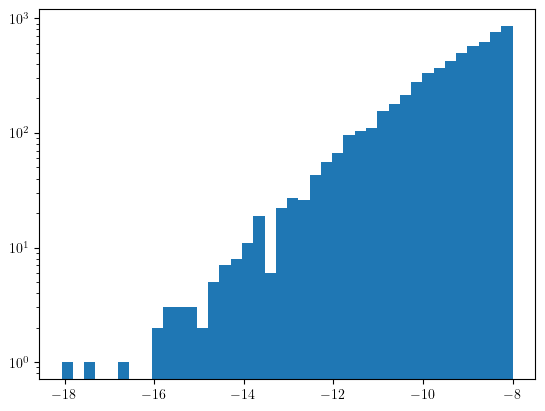

In [20]:
%%time
proto_Es = np.random.randint(0, d, size=(int(L0)*l))
def calculate_Es(motif, proto_Es, R, l, d, L0, E_m):
    M = ((R==proto_Es).T).reshape(int(L0), l, d)
    Es = np.sum(M*motif.T, axis = (1, 2)) + E_m
    return Es
Es_idx = np.arange(int(L0))[Es < -8]
Es = Es[Es<-8]
print(len(Es_idx))
plt.hist(Es, bins = 40)
plt.yscale('log')

5947
[     9    274    453 ... 999086 999334 999765]
CPU times: user 1.36 s, sys: 410 ms, total: 1.77 s
Wall time: 408 ms


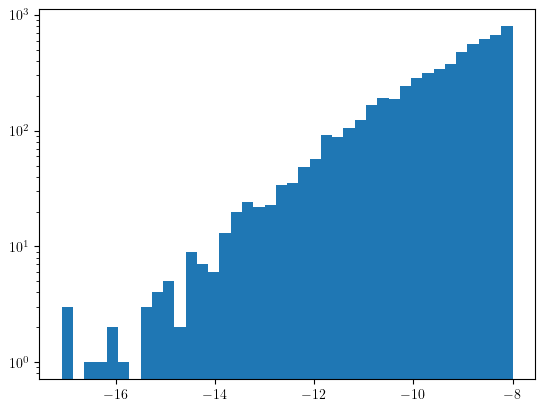

In [21]:
%%time
proto_Es = np.random.randint(0, d, size=(int(L0) * l))
Es = calculate_Es(motif, proto_Es, R, l, d, L0, E_m)
Es_idx = np.arange(int(L0))[Es < -8]
Es = Es[Es < -8]
print(len(Es_idx))
plt.hist(Es, bins = 40)
plt.yscale('log')
print(Es_idx)

In [36]:
Es[0], calculate_energy(motif, proto_Es.reshape(int(L0), l)[Es_idx][0]) + E_m


(-9.676983806055446, -9.676983806055446)

In [ ]:
%%time
# Attempt using permutations
%time proto_Es = np.zeros((int(L0), l, d))
%time proto_Es[:, :, -1] = 1
%time M = rng.permuted(M, axis = 2)
%time Es = np.sum(M*motif.T, axis = (1, 2)) + E_m
%time Es = Es[Es<0]
plt.hist(Es, bins = 40)
plt.yscale('log')